In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim import *
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import os
import numpy as np
import random
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from matplotlib import cm

dev = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

t = transforms.Compose([
                       transforms.Grayscale(),
                       transforms.ToTensor(),
                       transforms.Normalize([0.5], [0.5])]
                       )

train_dataset = torchvision.datasets.ImageFolder(
        root='data/mnist_png/training/',
        transform=t
    )
train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        num_workers=0,
        shuffle=True
    )

test_dataset = torchvision.datasets.ImageFolder(
        root='data/mnist_png/testing/',
        transform=t
    )
test_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=128,
        num_workers=0,
        shuffle=True
    )

In [2]:
# Build the neural network, expand on top of nn.Module
class Network(nn.Module):
    def __init__(self):
        super().__init__()

        # define layers
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5,5), padding=2)
        self.conv2 = nn.Conv2d(8, 16, kernel_size=(5,5), padding=2)
        self.conv3 = nn.Conv2d(16, 32, kernel_size=(5,5), padding=2)
        #self.conv4 = nn.Conv2d(32, 64, kernel_size=(3,3), padding=1)
        self.pool2 = nn.MaxPool2d(2, return_indices=True)
        self.drop = nn.Dropout(0.5)
        self.fc1 = nn.Linear(32*7*7, 256)
        self.fc2 = nn.Linear(256, 128)
        self.out = nn.Linear(in_features=128, out_features=10)

    # define forward function
    def forward(self, x):
        # conv 1
        x = self.drop(F.leaky_relu(self.conv1(x)))
        x, _ = self.pool2(x)
        x = self.drop(F.leaky_relu(self.conv2(x)))
        x, _ = self.pool2(x)
        x = self.drop(F.leaky_relu(self.conv3(x)))
        #x = F.leaky_relu(self.conv4(x))
        
        batch, _, _, _ = x.shape
        #x = F.adaptive_avg_pool2d(x, 1).reshape(batch, -1)
        x = x.reshape(batch, -1)
        x = self.drop(F.leaky_relu(self.fc1(x)))
        x = self.drop(F.leaky_relu(self.fc2(x)))

        # output
        x = self.out(x)
        # don't need softmax here since we'll use cross-entropy as activation.

        return x

In [3]:
classes = 10
model = Network().cuda()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001,
                             weight_decay=1e-4)
num_epochs=15
num_batches = len(train_loader) 
for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        img, labels = data
        #labels=to_categorical(labels,classes) 
        img=img.cuda()
        labels=labels.cuda()
        # ===================forward=====================
        output = model(img)
        loss = F.cross_entropy(output, labels)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        #if i%50==0:
        #    print('epoch [{}/{}], batch[{}/{}], loss:{:.4f}'.format(epoch+1,num_epochs, i,num_batches,  loss))
    # ===================log========================
    model.eval()
    loss_ts = []
    for i, data in enumerate(test_loader):
        img, labels = data
        img=img.cuda()
        labels=labels.cuda()
        # ===================forward=====================
        output = model(img.float())
        v_loss = F.cross_entropy(output, labels)
        loss_ts.append(v_loss.detach().cpu().numpy())    
    
    
    print('DONE with epoch [{}/{}], val loss:{:.4f}'.format(epoch+1, num_epochs, np.mean(loss_ts)))

DONE with epoch [1/15], val loss:0.2323
DONE with epoch [2/15], val loss:0.0419
DONE with epoch [3/15], val loss:0.0353
DONE with epoch [4/15], val loss:0.0474
DONE with epoch [5/15], val loss:0.0241
DONE with epoch [6/15], val loss:0.0196
DONE with epoch [7/15], val loss:0.0132
DONE with epoch [8/15], val loss:0.0206
DONE with epoch [9/15], val loss:0.0201
DONE with epoch [10/15], val loss:0.0139
DONE with epoch [11/15], val loss:0.0145
DONE with epoch [12/15], val loss:0.0127
DONE with epoch [13/15], val loss:0.0140
DONE with epoch [14/15], val loss:0.0076
DONE with epoch [15/15], val loss:0.0094


In [4]:
activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


model.fc2.register_forward_hook(get_activation('fc2'))

In [5]:
test_imgs = torch.zeros((0, 1, 28, 28), dtype=torch.float32)
test_predictions = []
test_targets = []
test_embeddings = torch.zeros((0, 128), dtype=torch.float32)
for x,y in test_loader:
    x = x.cuda()
    logits = model(x)
    preds = torch.argmax(logits, dim=1)
    test_predictions.extend(preds.detach().cpu().tolist())
    test_targets.extend(y.detach().cpu().tolist())
    embeddings = activation['fc2']
    test_embeddings = torch.cat((test_embeddings, embeddings.detach().cpu()), 0)
#    test_imgs = torch.cat((test_imgs, x.detach().cpu()), 0)
#test_imgs = np.array(test_imgs)
test_embeddings = np.array(test_embeddings)
test_targets = np.array(test_targets)
test_predictions = np.array(test_predictions)

In [6]:
test_embeddings.shape

(60000, 128)

In [7]:
pca = PCA(n_components=2)
pca.fit(test_embeddings)
pca_proj = pca.transform(test_embeddings)
pca.explained_variance_ratio_

array([0.23763742, 0.17418809], dtype=float32)

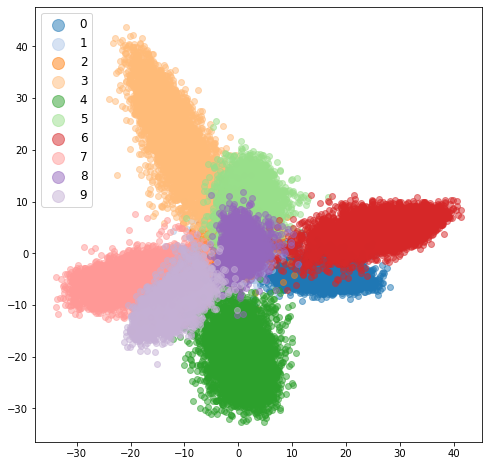

In [8]:


cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_predictions==lab
    ax.scatter(pca_proj[indices,0],pca_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()



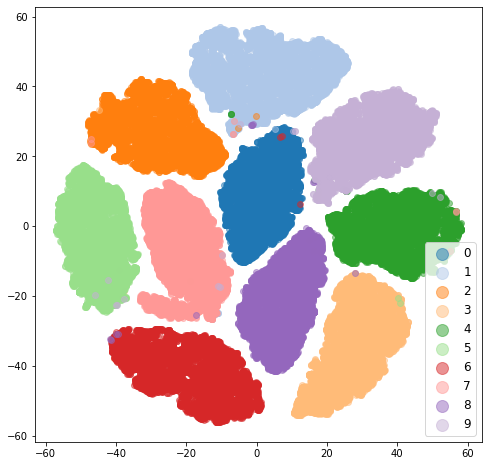

In [9]:
tsne = TSNE(2)
tsne_proj = tsne.fit_transform(test_embeddings)
# Plot those points as a scatter plot and label them based on the pred labels
cmap = cm.get_cmap('tab20')
fig, ax = plt.subplots(figsize=(8,8))
num_categories = 10
for lab in range(num_categories):
    indices = test_targets==lab
    ax.scatter(tsne_proj[indices,0],tsne_proj[indices,1], c=np.array(cmap(lab)).reshape(1,4), label = lab ,alpha=0.5)
ax.legend(fontsize='large', markerscale=2)
plt.show()

In [10]:
def fisher_score(X, Y, numclasses):
    mu = np.mean(X, axis = 0)
    num = np.zeros(mu.shape) - mu**2
    den = np.zeros(mu.shape)
    for c in range(numclasses):
        group = X[Y == c]
        n = group.shape[0]
        mu_c = np.mean(group, axis=0)
        sigma_c = np.std(group, axis =0)
        num = num + n*mu_c
        den = den + n*(sigma_c**2)
    return num/den

In [11]:
fisher_score(pca_proj, test_targets, 10)

array([-7.47996731e-07,  5.38346861e-07])

In [12]:
fisher_score(tsne_proj, test_targets, 10)

array([-0.00206815, -0.00155904])

In [13]:
def construct_dist_matrix(X, Y, numclasses):
    dmat = np.zeros((numclasses, numclasses))
    for i in range(numclasses):
        g_i = X[Y == i]
        for j in range(i, numclasses):
            g_j = X[Y == j]
            d = CSM(g_i, g_j)
            dmat[i,j] = d
            dmat[j,i] = d
    return dmat


def CSM(g1,g2):
    m1 = np.mean(g1, axis=0)
    m2 = np.mean(g2, axis=0)
    m = np.mean(np.concatenate((g1,g2), axis=0), axis=0)
    S_b = np.outer(m1-m,m1-m) + np.outer(m2-m,m2-m)
    S_w = np.zeros(S_b.shape)
    for i in range(g1.shape[0]):
        S_w = S_w + np.outer(g1[i] - m1, g1[i] - m1)
    for i in range(g2.shape[0]):
        S_w = S_w + np.outer(g2[i] - m2, g2[i] - m2)
        
    return np.matrix.trace(S_b)/np.matrix.trace(S_w)
            

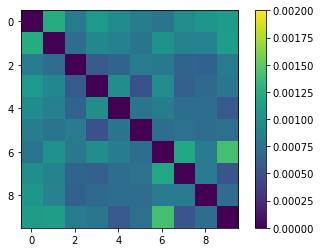

Frob norm for DM is 0.008133987631158366


In [14]:
DM = construct_dist_matrix(test_embeddings, test_targets,10)

fig, ax = plt.subplots()
im = ax.imshow(DM, vmin = 0, vmax = 2e-03)
fig.colorbar(im)
plt.show()
print("Frob norm for DM is " + str(np.linalg.norm(DM)))

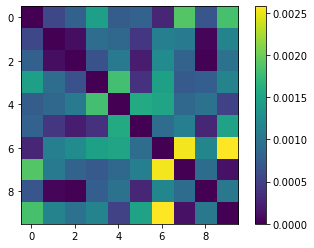

Frob norm for DM is 0.010704839730679908


In [15]:
DM = construct_dist_matrix(pca_proj, test_targets,10)

fig, ax = plt.subplots()
im = ax.imshow(DM)
fig.colorbar(im)
plt.show()
print("Frob norm for DM is " + str(np.linalg.norm(DM)))

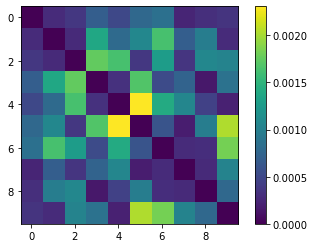

Frob norm for DM is 0.009409842475738731


In [16]:
DM = construct_dist_matrix(tsne_proj, test_targets,10)

fig, ax = plt.subplots()
im = ax.imshow(DM)
fig.colorbar(im)
plt.show()
print("Frob norm for DM is " + str(np.linalg.norm(DM)))